In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2024-10-07 11:04:07.860949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 11:04:07.860983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 11:04:07.862366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 11:04:07.870084: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = 'Dataset_BUSI_with_GT'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['benign', 'malignant']
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['benign', 'malignant']
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['benign', 'malignant']
)

Found 1619 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 349 images belonging to 2 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-10-07 11:05:24.309434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [6]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [9]:
# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2024-10-07 11:06:06.639297: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-10-07 11:06:10.221202: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb52052e120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-07 11:06:10.221232: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-10-07 11:06:10.229651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728299170.353065   21955 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 28s 441ms/step - loss: 0.7797 - accuracy: 0.7270 - val_loss: 0.3422 - val_accuracy: 0.8613
Epoch 2/10
51/51 [==============================] - 19s 381ms/step - loss: 0.3680 - accuracy: 0.8295 - val_loss: 0.3685 - val_accuracy: 0.8179
Epoch 3/10
51/51 [==============================] - 18s 357ms/step - loss: 0.2245 - accuracy: 0.9129 - val_loss: 0.3106 - val_accuracy: 0.8353
Epoch 4/10
51/51 [==============================] - 18s 353ms/step - loss: 0.1616 - accuracy: 0.9469 - val_loss: 0.2233 - val_accuracy: 0.9133
Epoch 5/10
51/51 [==============================] - 18s 353ms/step - loss: 0.1281 - accuracy: 0.9605 - val_loss: 0.2090 - val_accuracy: 0.9249
Epoch 6/10
51/51 [==============================] - 19s 367ms/step - loss: 0.1735 - accuracy: 0.9314 - val_loss: 0.2112 - val_accuracy: 0.9104
Epoch 7/10
51/51 [==============================] - 17s 339ms/step - loss: 0.0876 - accuracy: 0.9771 - val_loss: 0.1830 - val_accuracy: 0.9335
Epoch 8/10

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

11/11 [==============================] - 5s 475ms/step - loss: 0.2096 - accuracy: 0.9112
Test accuracy: 0.9111747741699219


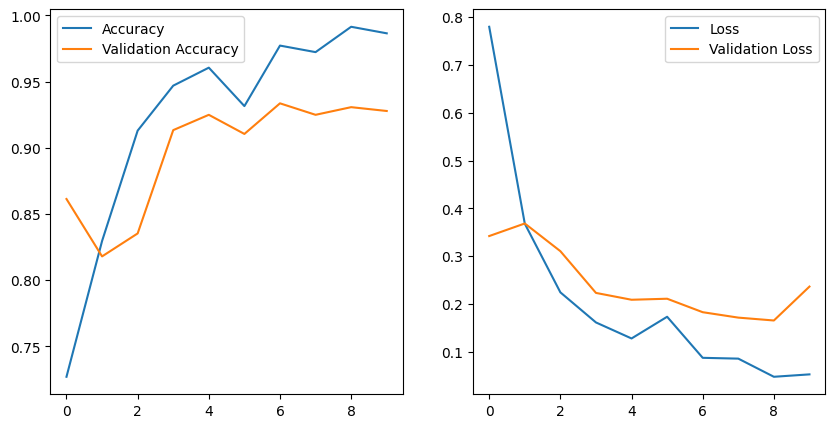

In [13]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [14]:
predictions = model.predict(test_generator)

11/11 [==============================] - 4s 297ms/step


In [15]:
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

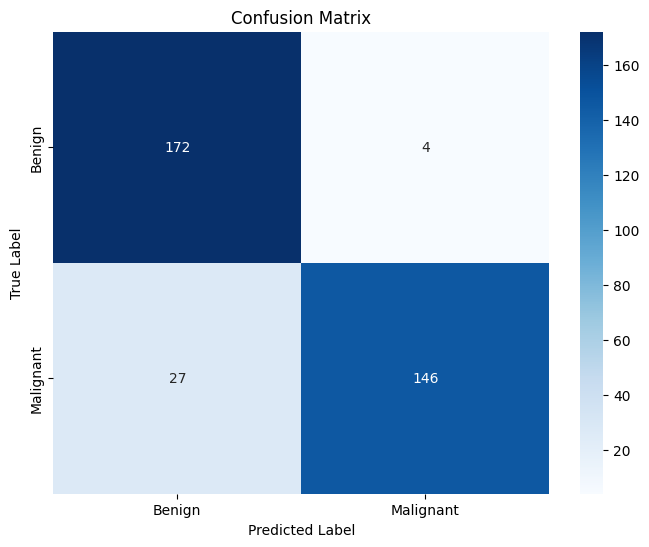

In [16]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)

#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
from keras.preprocessing import image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224,224))  # Adjust target size as needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

def predict_single_image(model, image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return prediction

In [23]:
image_path = './Dataset_BUSI_with_GT/benign/benign (3).png'  # Replace with the actual image filename
prediction = predict_single_image(model, image_path)
prediction

1/1 [==============================] - 0s 29ms/step


array([[6.130163e-06]], dtype=float32)